# 🧪 전통적인 머신러닝 기반 Inverse Problem 실험

이 실험은 ODE 시스템에서 생성된 시계열 데이터를 입력으로 하여, 해당 데이터를 생성한 ODE 파라미터를 추정하는 문제를 전통적인 머신러닝 회귀 모델들로 해결해보는 것을 목표로 한다.  
이를 통해 각 모델이 inverse problem에서 얼마나 잘 작동하는지를 비교하고자 한다.

- 입력: 시계열 trajectory (flattened)
- 출력: ODE 파라미터 (e.g., Lotka-Volterra system의 α, β)
- 비교 모델:
  - LinearRegression, Ridge, Lasso, BayesianRidge
  - SVR
  - RandomForest
  - GaussianProcessRegressor


In [1]:
import numpy as np
import os

dir_name = 'lotka_volterra'
file_stem = 'lotkavolterra'  # 저장 시 이렇게 저장되었음

def load_dataset(dir_name, file_stem=None):
    if file_stem is None:
        file_stem = dir_name.replace('_', '')  # 기본 룰 적용
    path = os.path.join('..', 'generated', dir_name, f'{file_stem}_dataset.npz')
    # Python 객체가 포함되어 있으므로 allow_pickle=True 필요
    return np.load(path, allow_pickle=True)

# 로드
data = load_dataset(dir_name, file_stem)

# 내용 확인
print(data.files)  # 예: ['params', 'x0', 'samples', 'time_steps', 'sols', 'dt', 'system_type']

# 예시 접근
params = data['params']        # shape: (10000, param_dim)
x0 = data['x0']                # shape: (10000, state_dim)
samples = data['samples']      # shape: (10000, T, D)
time_steps = data['time_steps']  # shape: (10000, T)
sols = data['sols']            # 리스트 형태로 저장된 solve_ivp 객체들


['params', 'x0', 'samples', 'time_steps', 'sols', 'dt', 'system_type']


In [2]:
import numpy as np
import pandas as pd
def convert_npz_to_dataframe(npz_data):
    """
    npz 데이터를 compact하게 sample 단위로 요약한 DataFrame을 생성합니다.
    각 sample은 하나의 row로, 
      - 관측 시계열 ('samples')와 time grid ('time_steps')는 list로,
      - 초기 조건 ('x0'), 파라미터 ('params'),
      - 그리고 ground truth trajectory (solve_ivp 객체의 y.T, 'sols')가 저장됩니다.
    """
    import pandas as pd
    
    params = npz_data['params']         # shape: (N, P)
    x0 = npz_data['x0']                 # shape: (N, D)
    samples = npz_data['samples']       # shape: (N, T, D)
    time_steps = npz_data['time_steps'] # shape: (N, T)
    sols = npz_data['sols']             # list of solve_ivp objects, 길이 N
    
    N, T, D = samples.shape
    records = []
    for i in range(N):
        # true trajectory는 각 solve_ivp 객체의 y.T (shape: (T_full, D))를 리스트로 변환
        try:
            true_traj = sols[i].y.T.tolist()  
        except Exception as e:
            true_traj = None
        
        row = {
            'sample_idx': i,
            'x0': list(x0[i]),
            'params': list(params[i]),
            'times': list(time_steps[i]),
            'true_trajectory': true_traj  # ground truth trajectory
        }
        # 각 상태 변수에 대한 관측 시계열 (noisy observations)
        for d in range(D):
            row[f'state_{d}'] = list(samples[i, :, d])
        records.append(row)
    
    df = pd.DataFrame(records)
    return df

In [3]:
df = convert_npz_to_dataframe(data)

df

,sample_idx,x0,params,times,true_trajectory,state_0,state_1
0,0,"[9.49816047538945, 5.901428612819832]","[1.092797576724562, 0.10394633936788146, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.49816047538945, 5.901428612819832], [9.984...","[9.81400303849093, 23.820310985254146, 38.1766...","[6.054915558650414, 3.9254945106096795, 15.330..."
1,1,"[8.798695128633439, 5.028468876827223]","[1.036965827544817, 0.08185801650879991, 0.065...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[8.798695128633439, 5.028468876827223], [9.38...","[8.678567390649677, 26.859757077121937, 57.173...","[4.970130126868568, 2.7361512889073656, 18.912..."
2,2,"[9.554709158757928, 4.542698063547792]","[1.1314950036607718, 0.09427013306774357, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.554709158757928, 4.542698063547792], [10.2...","[9.619525952636888, 28.957527795169433, 23.387...","[4.4656816074645285, 4.469653296971071, 28.371..."
3,3,"[11.548850970305306, 4.944429850323899]","[0.8478376983753207, 0.1085297914889198, 0.076...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.548850970305306, 4.944429850323899], [11....","[11.541685762483317, 22.448197486321202, 38.24...","[5.2573585814867005, 2.911255710608391, 8.8830..."
4,4,"[11.214688307596457, 4.3731401177720715]","[1.1570235993959912, 0.10157368967662603, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.214688307596457, 4.3731401177720715], [12...","[11.074277688820986, 33.87231650253858, 15.072...","[4.307607688452518, 4.835836669578541, 26.3914..."
...,...,...,...,...,...,...,...
9995,9995,"[9.06674222472362, 5.3645536793597985]","[0.9480434487307816, 0.08078143951745678, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.06674222472362, 5.3645536793597985], [9.56...","[9.060958052312612, 23.83030903981786, 39.8795...","[5.196456735516876, 2.5995442412260426, 19.755..."
9996,9996,"[10.686058521731491, 4.239487630890881]","[1.0278582369298326, 0.09260471597377619, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.686058521731491, 4.239487630890881], [11....","[10.811219441088685, 28.16398830048308, 22.769...","[4.462505947047643, 4.874626080613738, 24.3013..."
9997,9997,"[10.65100326033214, 5.273218015173407]","[0.838361935376518, 0.11046376636499679, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.65100326033214, 5.273218015173407], [10.9...","[10.61096153260883, 18.956532493649554, 32.991...","[5.4727168018515835, 3.663571098487103, 6.0885..."
9998,9998,"[11.919242342013689, 5.0723115827422385]","[1.0752165747222993, 0.08828518687956767, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.919242342013689, 5.0723115827422385], [12...","[11.653639391931149, 29.769390760639084, 19.65...","[5.072443068170984, 6.646510368944044, 25.6346..."


In [4]:
def split_dataframe(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
    """
    각 sample이 row인 DataFrame을 train, validation, test set으로 분할합니다.
    이 DataFrame은 관측 시계열, 실제(ground truth) trajectory, 초기조건, 파라미터 등의 정보를 포함합니다.
    
    Args:
        df (pd.DataFrame): 전체 데이터셋 (각 row가 하나의 sample)
        train_ratio (float): 학습 데이터 비율
        val_ratio (float): 검증 데이터 비율
        test_ratio (float): 테스트 데이터 비율
        seed (int, optional): 랜덤 시드
        
    Returns:
        tuple: (train_df, val_df, test_df)
    """
    import pandas as pd
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "비율의 합은 1이어야 합니다"
    
    if seed is not None:
        df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
    
    n = len(df_shuffled)
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)
    
    train_df = df_shuffled.iloc[:train_end].reset_index(drop=True)
    val_df = df_shuffled.iloc[train_end:val_end].reset_index(drop=True)
    test_df = df_shuffled.iloc[val_end:].reset_index(drop=True)
    
    return train_df, val_df, test_df


In [5]:
train_df, val_df, test_df = split_dataframe(df, seed=42)

In [6]:
def extract_timeseries_and_params(df):
    """
    compact dataframe에서 (시계열, 파라미터) 쌍 리스트 추출
    Returns:
        List[Tuple[np.ndarray, np.ndarray]]
    """
    data = []
    for _, row in df.iterrows():
        # 하나의 시계열: 모든 state 차원을 하나로 concat → shape (T, D)
        states = np.stack([row[f'state_{d}'] for d in range(len(row['x0']))], axis=1)
        params = np.array(row['params'])  # shape: (param_dim,)
        data.append((states, params))
    return data

In [7]:
train_data = extract_timeseries_and_params(train_df)
val_data = extract_timeseries_and_params(val_df)
test_data = extract_timeseries_and_params(test_df)

In [11]:
df

,sample_idx,x0,params,times,true_trajectory,state_0,state_1
0,0,"[9.49816047538945, 5.901428612819832]","[1.092797576724562, 0.10394633936788146, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.49816047538945, 5.901428612819832], [9.984...","[9.81400303849093, 23.820310985254146, 38.1766...","[6.054915558650414, 3.9254945106096795, 15.330..."
1,1,"[8.798695128633439, 5.028468876827223]","[1.036965827544817, 0.08185801650879991, 0.065...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[8.798695128633439, 5.028468876827223], [9.38...","[8.678567390649677, 26.859757077121937, 57.173...","[4.970130126868568, 2.7361512889073656, 18.912..."
2,2,"[9.554709158757928, 4.542698063547792]","[1.1314950036607718, 0.09427013306774357, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.554709158757928, 4.542698063547792], [10.2...","[9.619525952636888, 28.957527795169433, 23.387...","[4.4656816074645285, 4.469653296971071, 28.371..."
3,3,"[11.548850970305306, 4.944429850323899]","[0.8478376983753207, 0.1085297914889198, 0.076...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.548850970305306, 4.944429850323899], [11....","[11.541685762483317, 22.448197486321202, 38.24...","[5.2573585814867005, 2.911255710608391, 8.8830..."
4,4,"[11.214688307596457, 4.3731401177720715]","[1.1570235993959912, 0.10157368967662603, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.214688307596457, 4.3731401177720715], [12...","[11.074277688820986, 33.87231650253858, 15.072...","[4.307607688452518, 4.835836669578541, 26.3914..."
...,...,...,...,...,...,...,...
9995,9995,"[9.06674222472362, 5.3645536793597985]","[0.9480434487307816, 0.08078143951745678, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.06674222472362, 5.3645536793597985], [9.56...","[9.060958052312612, 23.83030903981786, 39.8795...","[5.196456735516876, 2.5995442412260426, 19.755..."
9996,9996,"[10.686058521731491, 4.239487630890881]","[1.0278582369298326, 0.09260471597377619, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.686058521731491, 4.239487630890881], [11....","[10.811219441088685, 28.16398830048308, 22.769...","[4.462505947047643, 4.874626080613738, 24.3013..."
9997,9997,"[10.65100326033214, 5.273218015173407]","[0.838361935376518, 0.11046376636499679, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.65100326033214, 5.273218015173407], [10.9...","[10.61096153260883, 18.956532493649554, 32.991...","[5.4727168018515835, 3.663571098487103, 6.0885..."
9998,9998,"[11.919242342013689, 5.0723115827422385]","[1.0752165747222993, 0.08828518687956767, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.919242342013689, 5.0723115827422385], [12...","[11.653639391931149, 29.769390760639084, 19.65...","[5.072443068170984, 6.646510368944044, 25.6346..."


In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

param_grids = {
            "Ridge": {"estimator__alpha": [1e-2, 0.1, 1.0, 10.0, 100.0]},
            "Lasso": {"estimator__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 0.1]},
            "SVR": {
                        "estimator__kernel": ["linear", "rbf"],
                        "estimator__C": [0.1, 1.0, 10.0],
                        "estimator__gamma": ["scale", 0.1]
                    }
                    ,
            "RandomForest": {
                "n_estimators": [50, 100, 200],
                "max_depth": [5, 10, 20, None]
            },
            "GaussianProcess": {
                "estimator__alpha": [1e-2, 1e-1],
                "estimator__kernel": [RBF(length_scale=l) for l in [0.1, 1.0, 10.0]]
            }
}



# 2. Prepare input-output matrices
def make_input_output(df, state_dims):
    X = []
    y = []
    for _, row in df.iterrows():
        x_i = []
        for d in range(state_dims):
            x_i += row[f'state_{d}']
        X.append(x_i)
        y.append(row['params'])
    return np.array(X), np.array(y)

# 3. Model candidates


model_wrappers = {
    "LinearRegression": LinearRegression(),
    "Ridge": MultiOutputRegressor(Ridge()),
    "Lasso": MultiOutputRegressor(Lasso()),
    "BayesianRidge": MultiOutputRegressor(BayesianRidge()),
    "SVR": MultiOutputRegressor(SVR()),
    "RandomForest": RandomForestRegressor(random_state=0),
    "GaussianProcess": MultiOutputRegressor(GaussianProcessRegressor(kernel=RBF(), alpha=1e-2))
}

# 4. Run experiment
def run_models(df, state_dims=2):
    train_df, val_df, test_df = split_dataframe(df)
    X_train, y_train = make_input_output(train_df, state_dims)
    X_val, y_val = make_input_output(val_df, state_dims)
    X_test, y_test = make_input_output(test_df, state_dims)

    results = []
    best_models = {}

    for name, model in model_wrappers.items():
        param_grid = param_grids.get(name, {})

        if param_grid:  # apply GridSearchCV if tuning needed
            search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
        else:
            model.fit(X_train, y_train)
            best_model = model

        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "model": name,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        })
        best_models[name] = best_model

    results_df = pd.DataFrame(results)
    return results_df, best_models, (X_test, y_test)

# Run the full experiment
results_df, trained_models, test_data = run_models(df)

/home/shlee/miniconda3/envs/vision_task/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e-01, tolerance: 6.361e-03
  model = cd_fast.enet_coordinate_descent(
/home/shlee/miniconda3/envs/vision_task/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.315e-01, tolerance: 6.301e-03
  model = cd_fast.enet_coordinate_descent(
/home/shlee/miniconda3/envs/vision_task/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

In [17]:
results_df

,model,MSE,MAE,R2
0,LinearRegression,0.000744,0.016503,0.912495
1,Ridge,0.000744,0.016503,0.912499
2,Lasso,0.000744,0.016503,0.912501
3,BayesianRidge,0.000744,0.016503,0.912505
4,SVR,0.000880,0.020759,0.457146
5,RandomForest,0.001139,0.020689,0.813633
6,GaussianProcess,0.000290,0.011259,0.835714


/tmp/ipykernel_967325/36376126.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.sort_values("MSE"), x="model", y="MSE", palette="Set2")


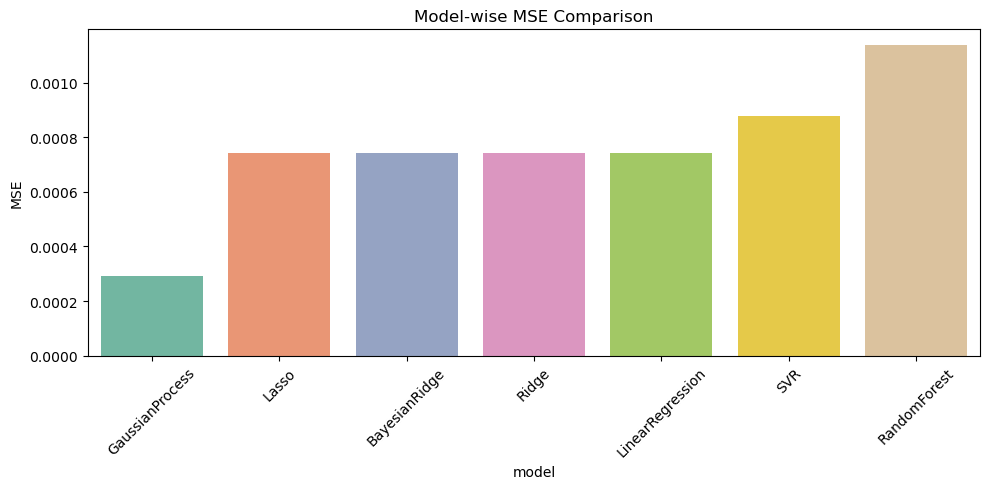

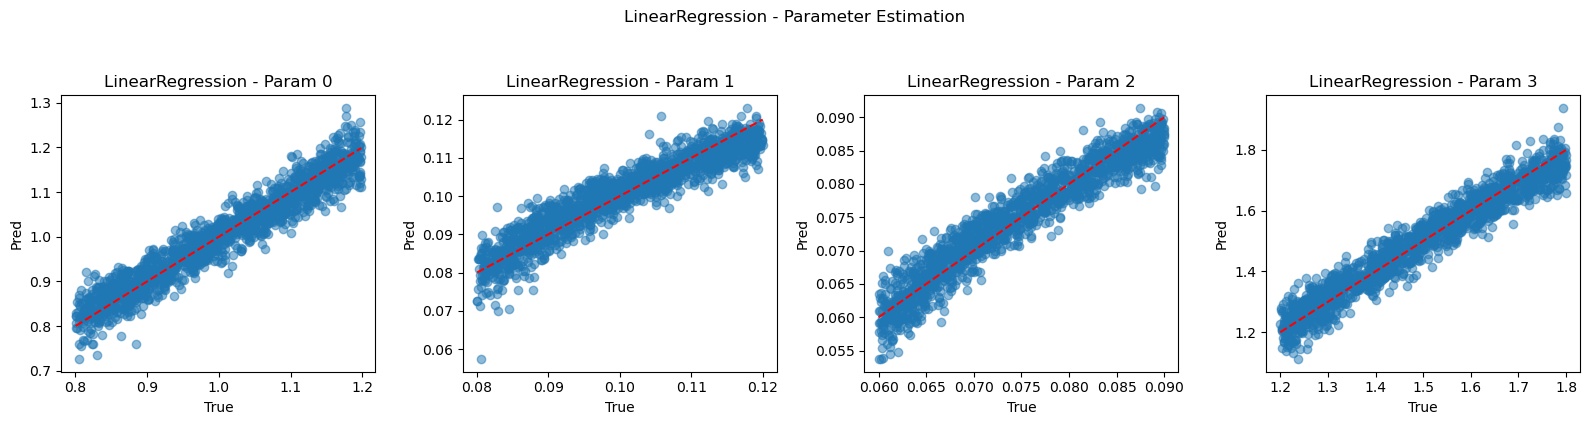

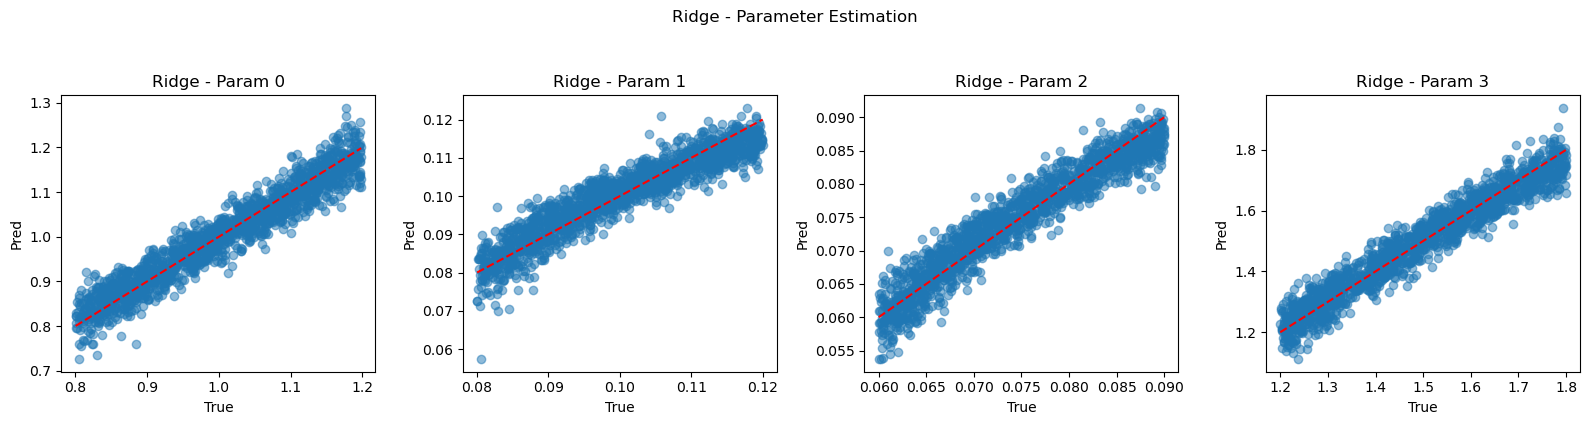

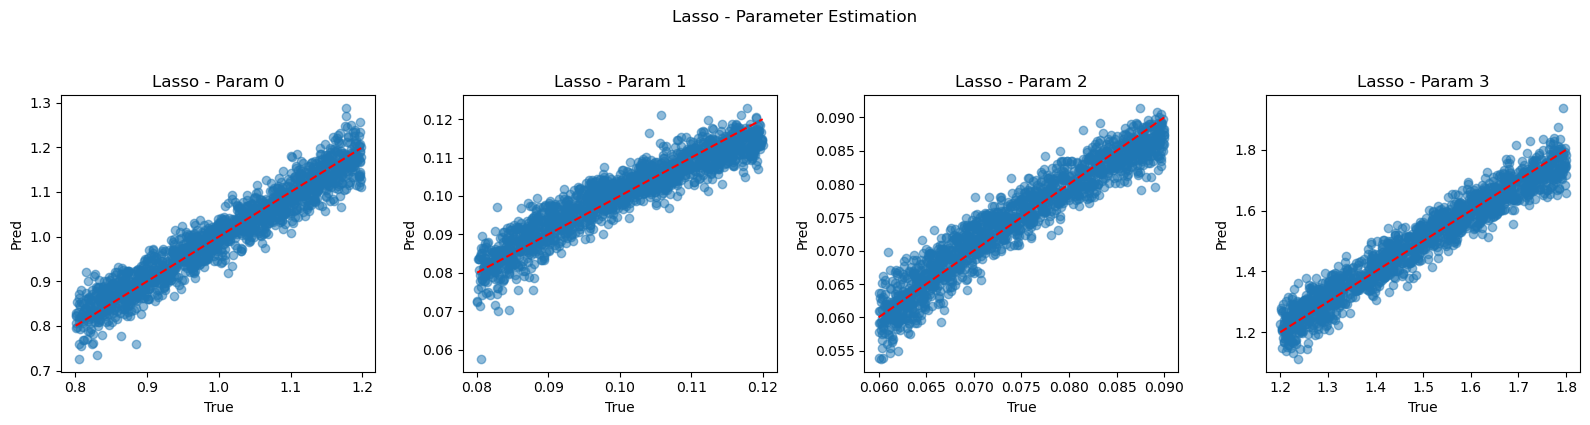

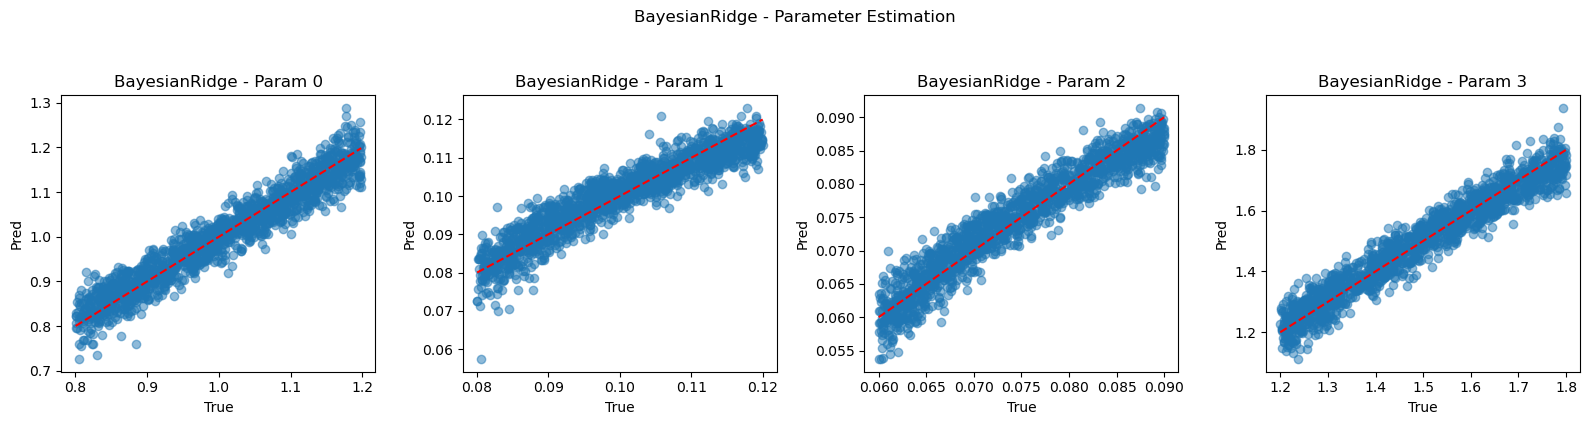

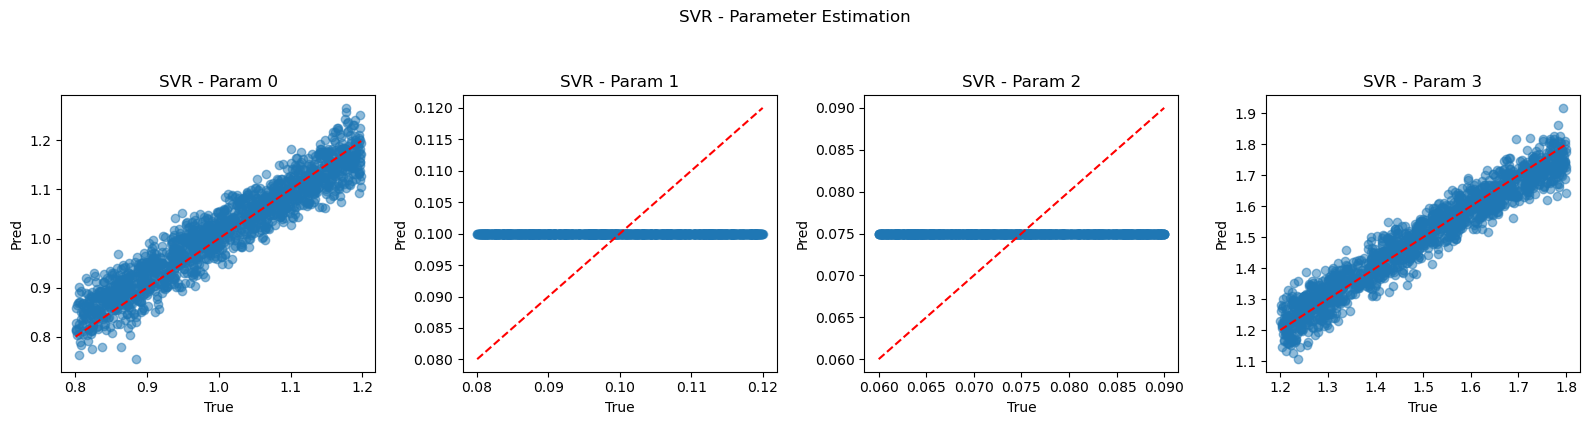

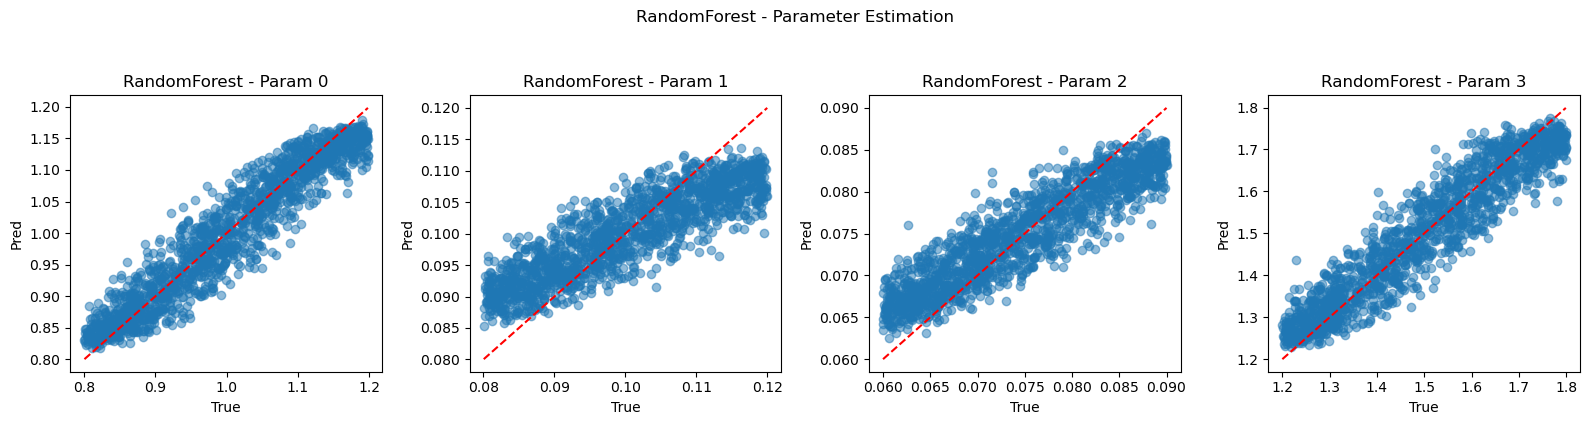

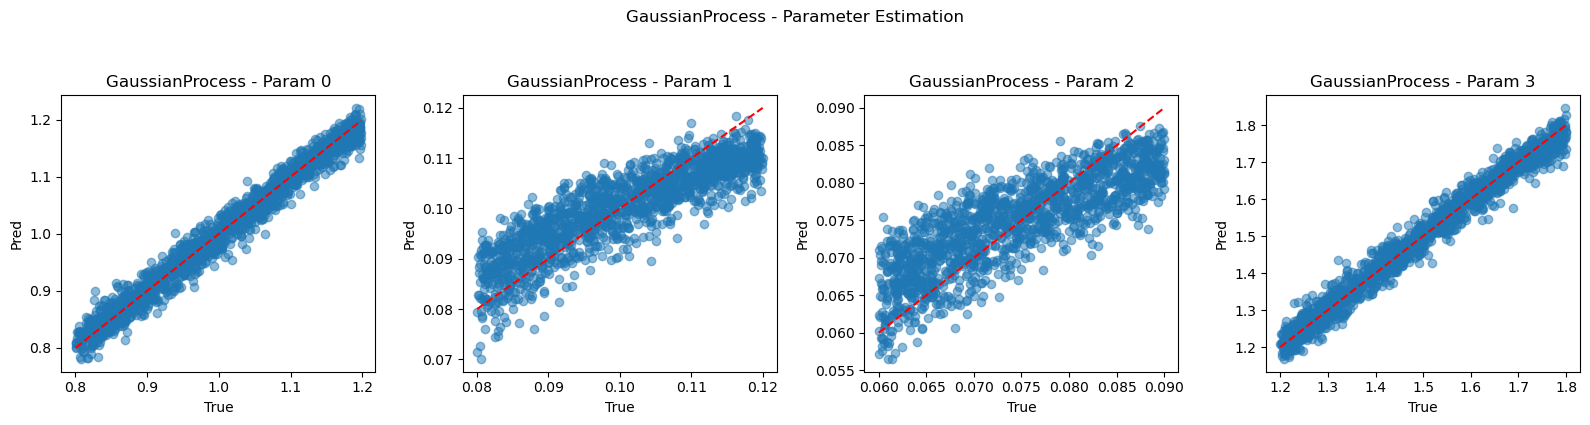

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack test data
X_test, y_test = test_data

# Predict and store all model outputs
model_preds = {name: model.predict(X_test) for name, model in trained_models.items()}

# 1. 모델별 MSE 스코어 바 플롯
def plot_model_mse(results_df):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df.sort_values("MSE"), x="model", y="MSE", palette="Set2")
    plt.title("Model-wise MSE Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. 모델별 각 파라미터에 대해 y=x 선과 함께 산점도 비교
def plot_param_scatter(y_true, y_pred_dict):
    n_params = y_true.shape[1]
    for model_name, y_pred in y_pred_dict.items():
        fig, axes = plt.subplots(1, n_params, figsize=(4 * n_params, 4))
        for i in range(n_params):
            ax = axes[i] if n_params > 1 else axes
            ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
            ax.plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()], 'r--')
            ax.set_title(f"{model_name} - Param {i}")
            ax.set_xlabel("True")
            ax.set_ylabel("Pred")
        plt.suptitle(f"{model_name} - Parameter Estimation", y=1.05)
        plt.tight_layout()
        plt.show()

plot_model_mse(results_df)
plot_param_scatter(y_test, model_preds)


In [ ]:
from scipy.integrate import solve_ivp

# Define the Lotka-Volterra ODE system
def lotka_volterra_ode(t, z, theta):
    alpha, beta, delta, gamma = theta
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Reconstruct trajectory given predicted parameters
def reconstruct_trajectory(f, x0, t_eval, theta_pred):
    sol = solve_ivp(fun=lambda t, z: f(t, z, theta_pred), 
                    t_span=(t_eval[0], t_eval[-1]),
                    y0=x0,
                    t_eval=t_eval,
                    method='RK45')
    return sol.y.T  # shape: (T, D)

# Calculate reconstruction error for each test sample and model
def compute_reconstruction_errors(best_models, test_df):
    model_errors = {name: [] for name in best_models}
    recon_trajectories = {name: [] for name in best_models}

    for _, row in test_df.iterrows():
        x0 = row['x0']
        t_eval = row['times']
        D = len(x0)

        # 관측값 (shape: T × D)
        obs = np.column_stack([row[f'state_{d}'] for d in range(D)])

        # 모델별 추정 및 reconstruction
        for model_name, model in best_models.items():
            x_input = np.concatenate([row[f'state_{d}'] for d in range(D)]).reshape(1, -1)
            theta_hat = model.predict(x_input)[0]

            recon = reconstruct_trajectory(lotka_volterra_ode, x0, t_eval, theta_hat)
            recon_trajectories[model_name].append(recon)

            # Reconstruction error (MSE)
            error = np.mean((obs - recon) ** 2)
            model_errors[model_name].append(error)

    return model_errors, recon_trajectories

# Prepare test_df again from df
_, _, test_df = split_dataframe(df)

# Run reconstruction error analysis
recon_errors, recon_trajectories = compute_reconstruction_errors(trained_models, test_df)


rows = []
for model_name, errors in recon_errors.items():
    rows.append({
        "model": model_name,
        "mean_recon_MSE": np.mean(errors)
    })

recon_error_df = pd.DataFrame(rows)


In [22]:
recon_error_df

,model,mean_recon_MSE
0,LinearRegression,1.524307
1,Ridge,1.524184
2,Lasso,1.532054
3,BayesianRidge,1.523781
4,SVR,15.866833
5,RandomForest,0.963843
6,GaussianProcess,4.370787


Reconstruction Error Summary:
              model  mean_recon_MSE
0  LinearRegression        1.507556
1             Ridge        1.507413
2             Lasso        1.514813
3     BayesianRidge        1.507008
4               SVR       15.847542
5      RandomForest        0.975678
6   GaussianProcess        4.333210


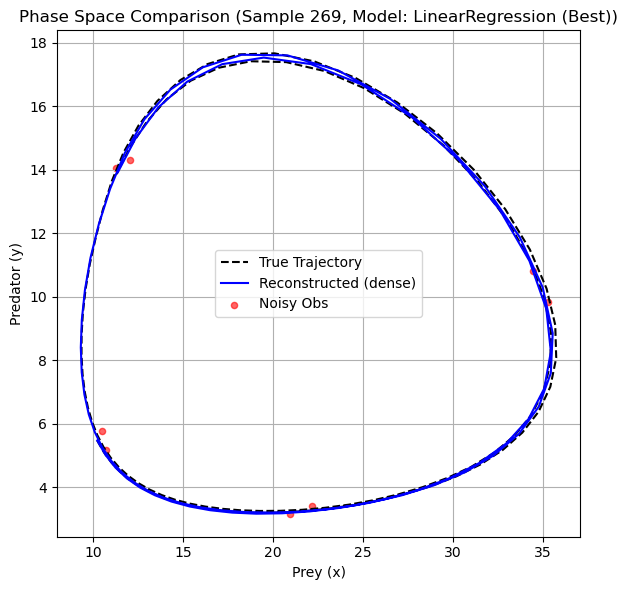

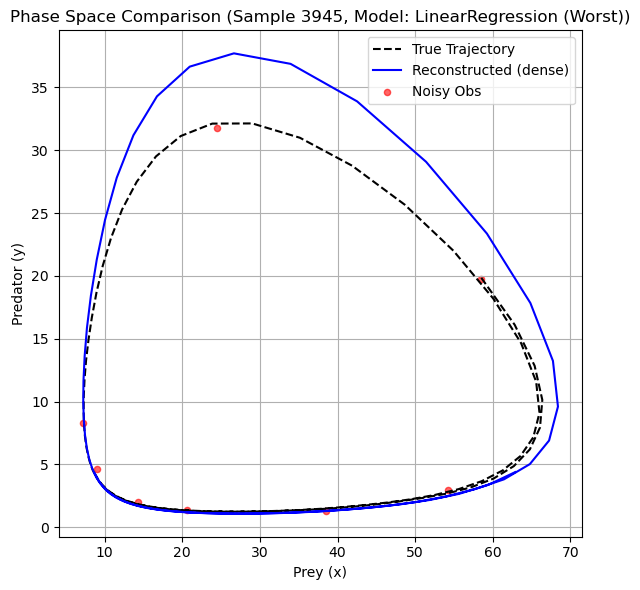

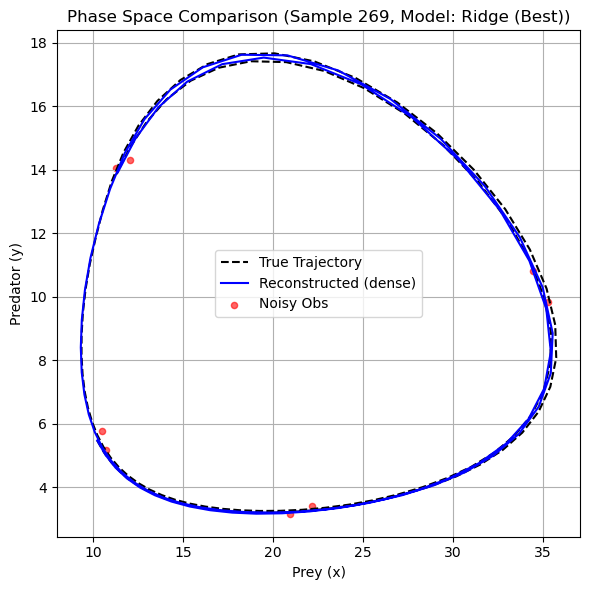

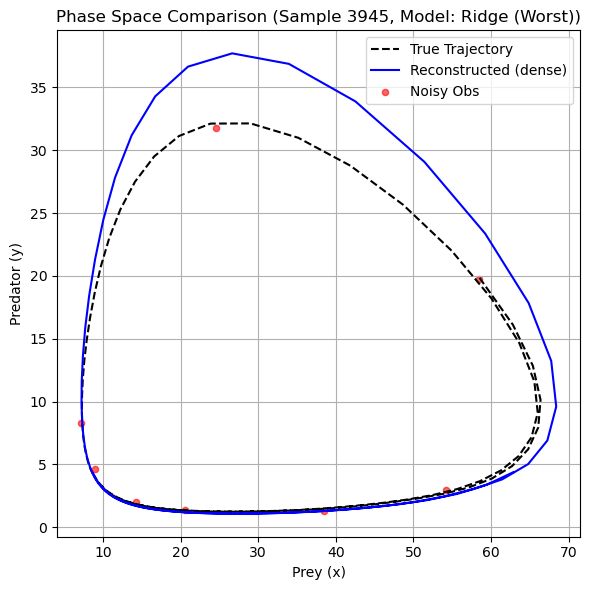

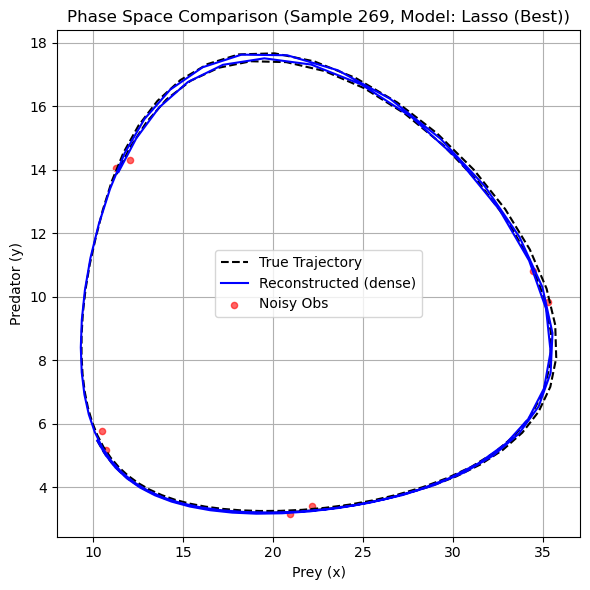

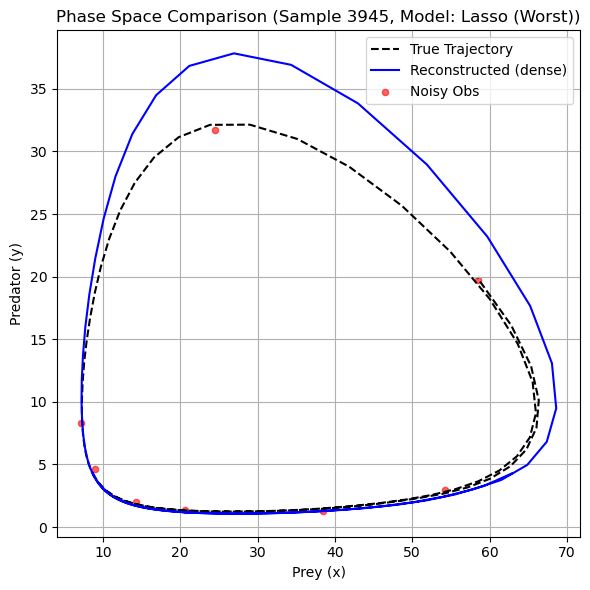

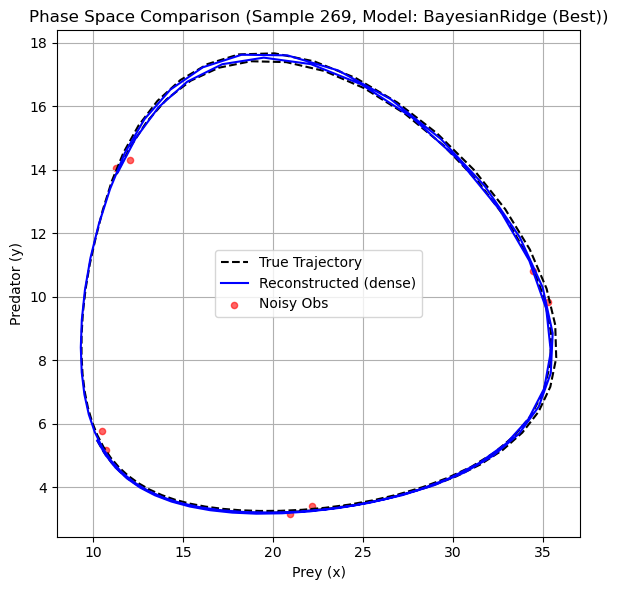

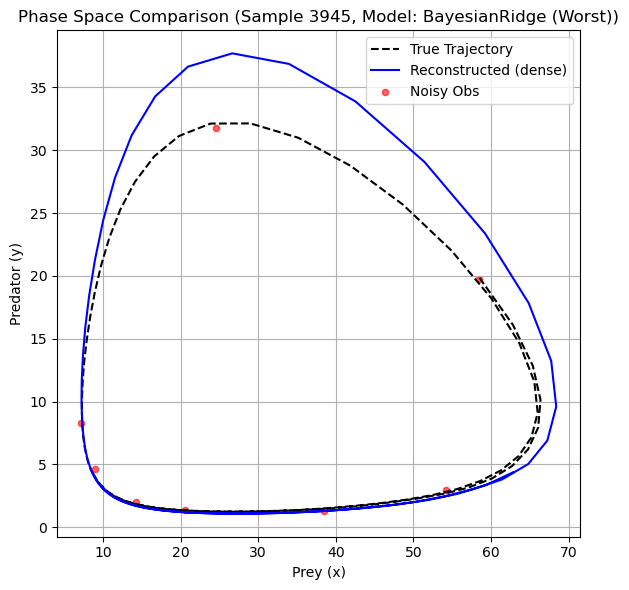

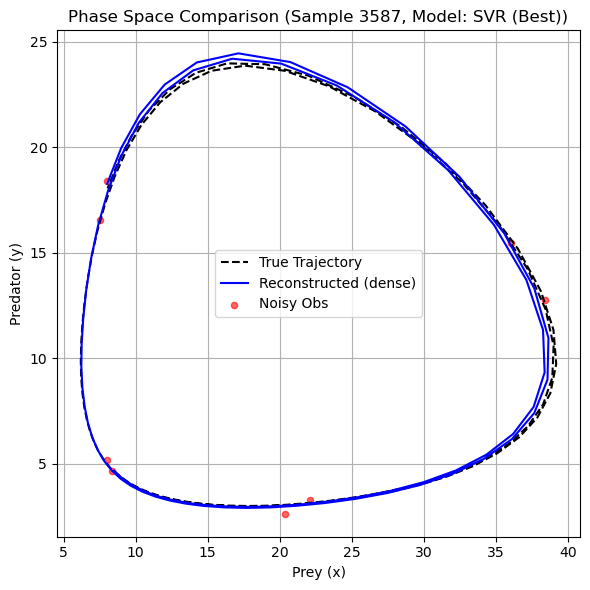

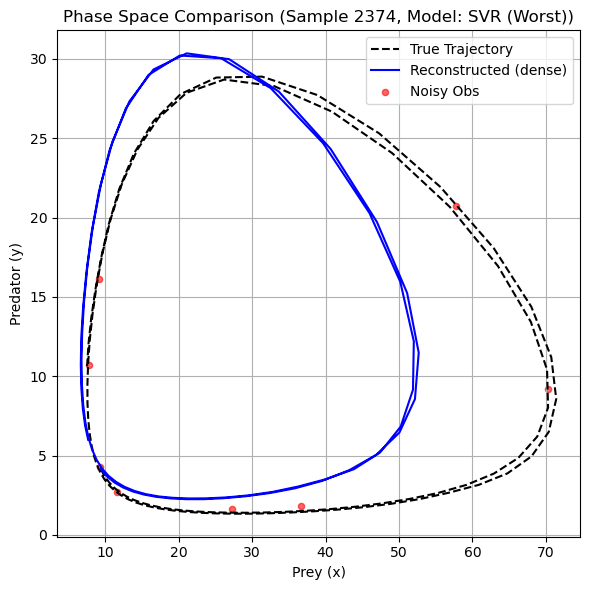

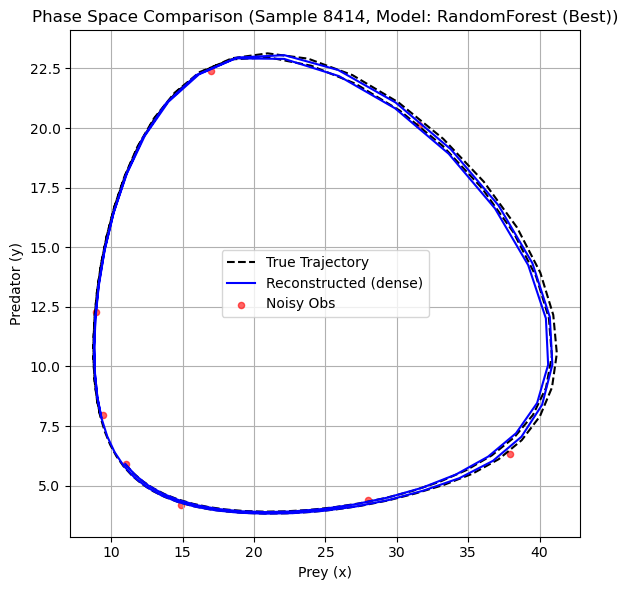

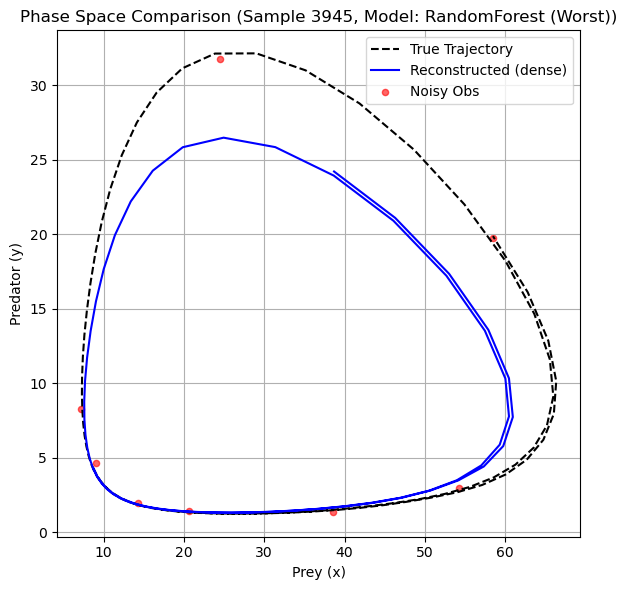

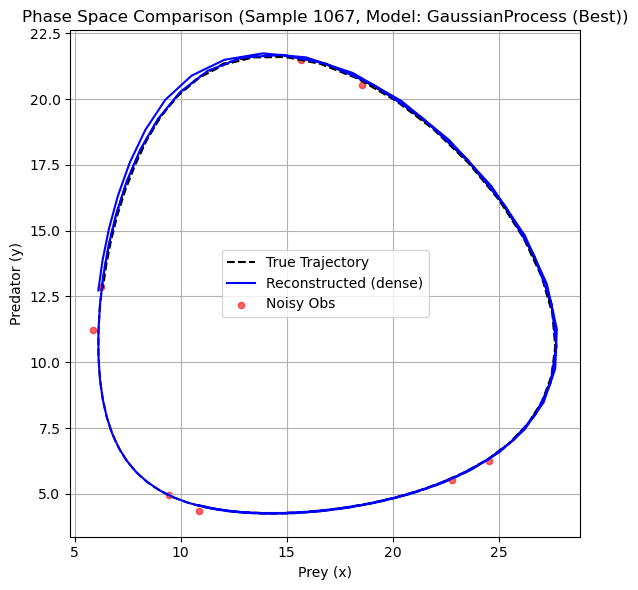

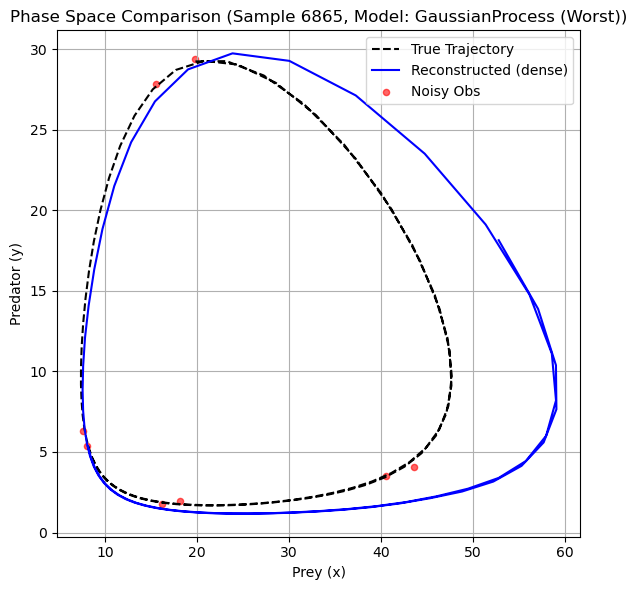

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

############################################
# 1. Lotka–Volterra ODE 정의
############################################
def lotka_volterra_ode(t, z, theta):
    alpha, beta, delta, gamma = theta
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

############################################
# 2. Dense Reconstruction 함수
############################################
def reconstruct_trajectory_dense(f, x0, t_eval, theta_pred):
    """
    ODE를 dense_output 옵션을 사용해 풀고, 기존 t_eval보다 촘촘한 시간 그리드를 생성하여 부드러운 해를 반환.
    """
    sol = solve_ivp(fun=lambda t, z: f(t, z, theta_pred), 
                    t_span=(t_eval[0], t_eval[-1]),
                    y0=x0,
                    dense_output=True,
                    method='RK45')
    # t_eval의 10배 해상도로 dense time grid 생성
    t_dense = np.linspace(t_eval[0], t_eval[-1], num=len(t_eval) * 10)
    recon_dense = sol.sol(t_dense).T  # shape: (T_dense, D)
    return recon_dense, t_dense

############################################
# 3. Dense 기반 Reconstruction error 계산 함수
############################################
def compute_reconstruction_errors_dense(best_models, test_df):
    """
    각 모델에 대해 dense reconstruction을 수행하고, 
    t_eval에서 관측값과 보간(interpolation)하여 reconstruction error(MSE)를 계산한다.
    
    Returns:
      model_errors: {model_name: [error_sample1, error_sample2, ...]}
      recon_trajectories: {model_name: [recon_dense_sample1, recon_dense_sample2, ...]}
      dense_time_grids: {model_name: [dense_time_grid_sample1, dense_time_grid_sample2, ...]}
    """
    model_errors = {name: [] for name in best_models}
    recon_trajectories = {name: [] for name in best_models}
    dense_time_grids = {name: [] for name in best_models}
    
    for _, row in test_df.iterrows():
        x0 = row['x0']
        t_eval = row['times']
        D = len(x0)
        # 관측값: shape (T, D)
        obs = np.column_stack([row[f'state_{d}'] for d in range(D)])
        
        for model_name, model in best_models.items():
            # 입력 벡터 구성 (flatten)
            x_input = np.concatenate([row[f'state_{d}'] for d in range(D)]).reshape(1, -1)
            theta_hat = model.predict(x_input)[0]
            
            # Dense reconstruction 수행
            recon_dense, t_dense = reconstruct_trajectory_dense(lotka_volterra_ode, x0, t_eval, theta_hat)
            recon_trajectories[model_name].append(recon_dense)
            dense_time_grids[model_name].append(t_dense)
            
            # 보간: dense reconstruction 결과를 t_eval에 맞춰 보간
            interp_recon = np.empty((len(t_eval), D))
            for d in range(D):
                interp_recon[:, d] = np.interp(t_eval, t_dense, recon_dense[:, d])
            error = np.mean((obs - interp_recon) ** 2)
            model_errors[model_name].append(error)
    
    return model_errors, recon_trajectories, dense_time_grids

############################################
# 4. 시각화 함수
############################################
# Phase space 비교를 위한 dense reconstruction plot 함수
def plot_phase_space_comparison_dense(sample_idx, true_traj, recon_dense, obs, model_name):
    plt.figure(figsize=(6, 6))
    # Ground truth trajectory (예: solve_ivp로 구한 trajectory)
    plt.plot(true_traj[:, 0], true_traj[:, 1], label="True Trajectory", linestyle='--', color='black')
    # Dense reconstruction trajectory
    plt.plot(recon_dense[:, 0], recon_dense[:, 1], label="Reconstructed (dense)", color='blue')
    # Noisy observation (discrete)
    plt.scatter(obs[:, 0], obs[:, 1], label="Noisy Obs", color='red', s=20, alpha=0.6)
    plt.xlabel("Prey (x)")
    plt.ylabel("Predator (y)")
    plt.title(f"Phase Space Comparison (Sample {sample_idx}, Model: {model_name})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Best/Worst sample 시각화를 위한 함수
def plot_best_worst_trajectories_dense(model_name, test_df, model_errors, recon_trajectories):
    errors = np.array(model_errors[model_name])
    best_idx = np.argmin(errors)
    worst_idx = np.argmax(errors)
    
    for idx in [best_idx, worst_idx]:
        row = test_df.iloc[idx]
        true_traj = np.array(row["true_trajectory"])
        D = len(row['x0'])
        obs = np.column_stack([row[f'state_{d}'] for d in range(D)])
        recon_dense = recon_trajectories[model_name][idx]
        label = "Best" if idx == best_idx else "Worst"
        plot_phase_space_comparison_dense(row["sample_idx"], true_traj, recon_dense, obs, f"{model_name} ({label})")

############################################
# 5. 최종 실행 예시
############################################
# 주의: 아래 변수들(test_df, best_models, tuned_results_df 등)은 이전 셀에서 데이터 로딩 및 모델 학습 후 생성된 변수여야 합니다.
# 예를 들어, test_df는 데이터 분할된 테스트 DataFrame, best_models는 튜닝된 모델들의 딕셔너리입니다.
#
# Dense reconstruction error 계산:
recon_errors_dense, recon_trajectories_dense, dense_time_grids = compute_reconstruction_errors_dense(trained_models, test_df)

# reconstruction error 요약 DataFrame 생성 (append() 대신 list 사용)
rows = []
for model_name, errors in recon_errors_dense.items():
    rows.append({
        "model": model_name,
        "mean_recon_MSE": np.mean(errors)
    })
recon_error_df_dense = pd.DataFrame(rows)
print("Reconstruction Error Summary:")
print(recon_error_df_dense)


for model_name in recon_error_df_dense['model']:
    plot_best_worst_trajectories_dense(model_name, test_df, recon_errors_dense, recon_trajectories_dense)
